# Role Discovery: Result Analysis

The primary objective is to compare the efficacy of two distinct approaches:

1.  **Traditional Method (`Feature-Based_Roles`)**: This method involves extracting a vector of structural features (e.g., centrality metrics, clustering coefficient) for each node and then applying K-Means clustering.
2.  **GNNs with Simple Features**: Unsupervised GNNs (`GAE`, `DGI`) learn node embeddings from the graph structure, using only node degrees as initial features.
3.  **GNNs with Graphlet Features**: The same GNNs are provided with pre-computed graphlet features as input, combining engineered features with learned representations.

The analysis is performed on three datasets: **Cora**, **Actor**, and **CLUSTER**. We will evaluate the models based on internal clustering metrics and qualitative analysis, aiming to answer the following key questions:

  - Which method produces better-separated roles (clusters)?
  - How do we determine the optimal number of roles, $k$?
  - Can we assign meaningful, interpretable labels (e.g., "hub," "bridge," "periphery") to the discovered roles?

  - How crucial are input features for graph neural networks in the context of role discovery?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
import sys
from IPython.display import display

warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(style="whitegrid", palette="magma")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

RESULTS_DIR = Path("results/role_discovery/")
DATASETS = ['Cora', 'Actor', 'CLUSTER']
MODELS = [
    "Feature-Based_Roles", "Feature-Based_Roles_Graphlets",
    "GNN_Embedder_GAE", "GNN_Embedder_GAE_Graphlets",
    "GNN_Embedder_DGI", "GNN_Embedder_DGI_Graphlets"
]

print(f"Analysis Notebook Setup Complete.")
print(f"Results Directory: {RESULTS_DIR.resolve()}")
print(f"Datasets to Analyze: {DATASETS}")


Analysis Notebook Setup Complete.
Results Directory: /home/adriano/Desktop/network-science/project/role_discovery/results/role_discovery
Datasets to Analyze: ['Cora', 'Actor', 'CLUSTER']


## 1\. High-Level Comparison Across All Datasets


In [2]:
summary_path = RESULTS_DIR / "comparison_summary.csv"
if not summary_path.exists():
    print(f"Error: The summary file was not found at {summary_path}")
    print("Please run `python -m project.role_discovery.generate_report` first.")
    summary_df = pd.DataFrame()
else:
    summary_df = pd.read_csv(summary_path)

print("--- Overall Model Performance (based on best Silhouette Score) ---")
if not summary_df.empty:
    display(summary_df.sort_values('Silhouette Score', ascending=False).style.format({
        'Silhouette Score': '{:.4f}',
        'Davies-Bouldin Index': '{:.4f}',
        'Calinski-Harabasz Index': '{:,.2f}'
    }))


--- Overall Model Performance (based on best Silhouette Score) ---


,Dataset,Model,Best k,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
11,Actor,GNN_Embedder_DGI_Graphlets,3,0.9659,0.1635,"4,971.14"
7,Actor,Feature-Based_Roles_Graphlets,3,0.9497,0.3327,"20,701.46"
1,Cora,Feature-Based_Roles_Graphlets,3,0.9372,0.3978,"3,544.17"
10,Actor,GNN_Embedder_GAE_Graphlets,3,0.8564,0.4948,"6,488.84"
5,Cora,GNN_Embedder_DGI_Graphlets,3,0.8292,0.3968,"17,989.63"
8,Actor,GNN_Embedder_GAE,3,0.7600,0.3474,"9,031.48"
9,Actor,GNN_Embedder_DGI,3,0.6952,0.5631,"6,426.50"
4,Cora,GNN_Embedder_GAE_Graphlets,4,0.6829,0.6265,"1,588.97"
3,Cora,GNN_Embedder_DGI,3,0.6339,0.5306,"3,315.86"
2,Cora,GNN_Embedder_GAE,3,0.6053,0.5799,"4,242.17"


### 1.1. Visualizing Overall Performance

We will create a separate plot for each key metric.
  - **Silhouette Score**: Higher is better. Measures how similar a node is to its own role compared to other roles.
  - **Davies-Bouldin Index**: Lower is better. Measures the average similarity ratio of each role with its most similar one.
  - **Calinski-Harabasz Index**: Higher is better. The ratio of between-cluster dispersion to within-cluster dispersion.


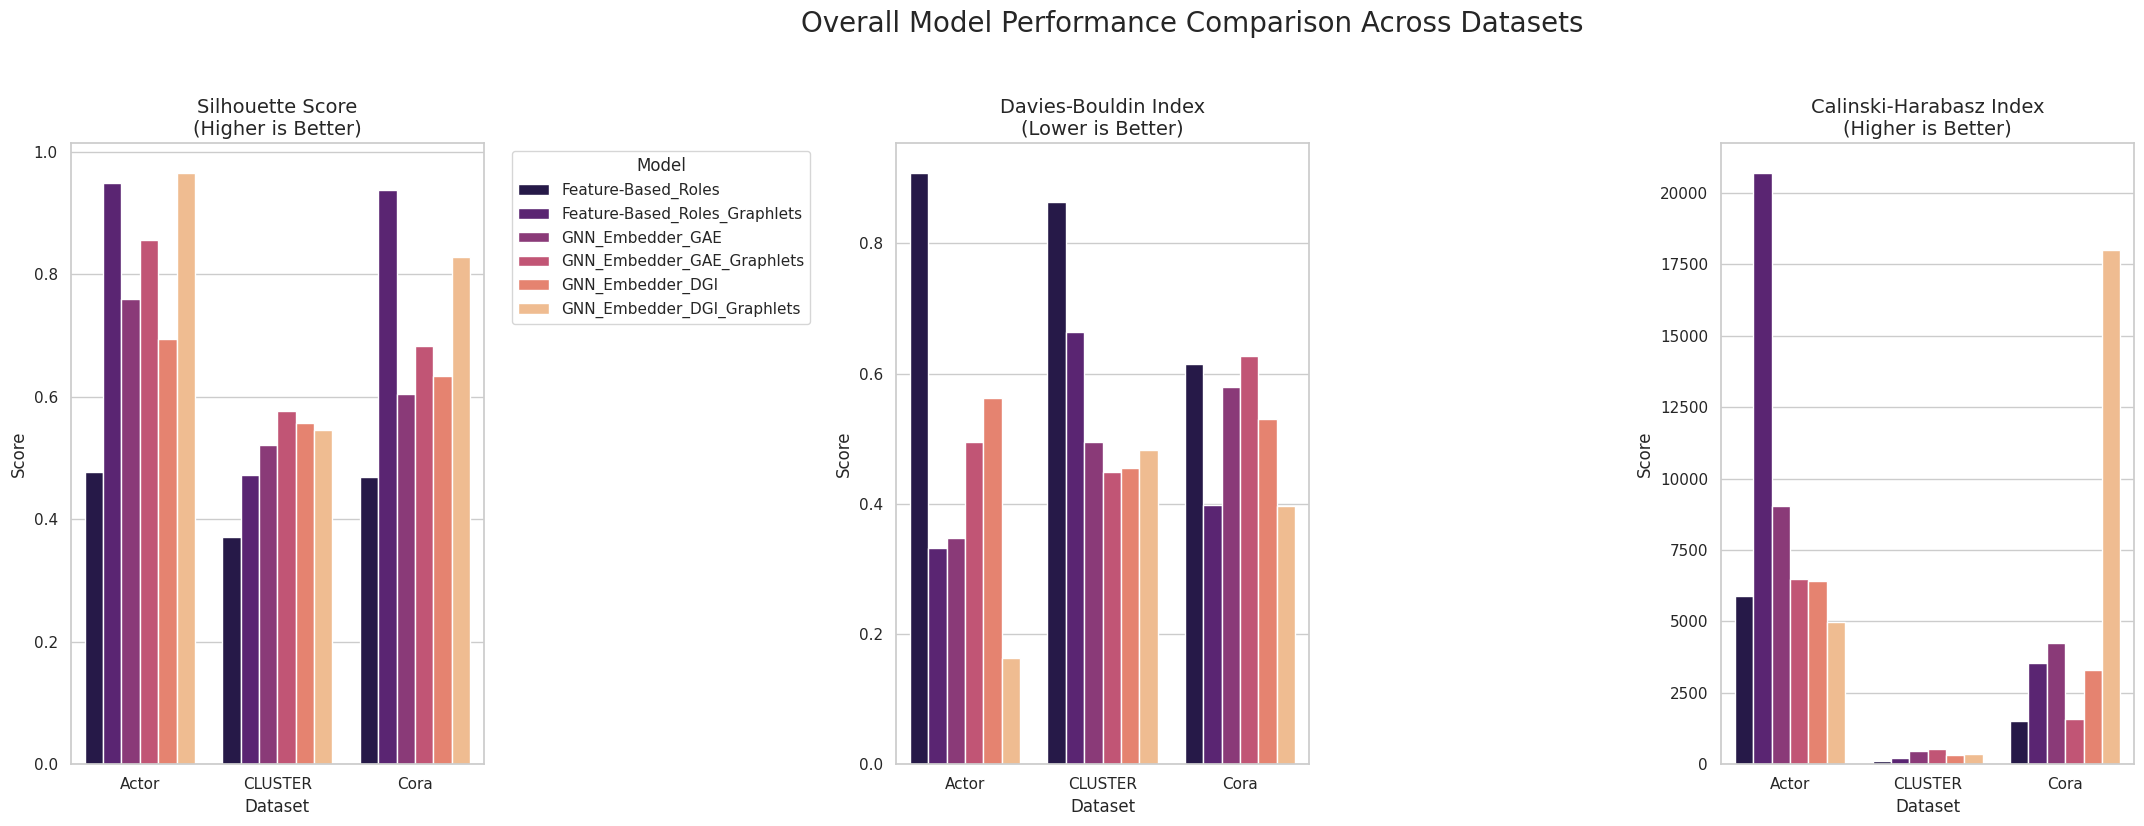

In [ ]:

if not summary_df.empty:
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle('Overall Model Performance Comparison Across Datasets', fontsize=20, y=1.03)

    metrics = [("Silhouette Score", "Higher is Better"),
               ("Davies-Bouldin Index", "Lower is Better"),
               ("Calinski-Harabasz Index", "Higher is Better")]

    for i, (metric, interpretation) in enumerate(metrics):
        sorted_df = summary_df.sort_values(by=['Dataset', 'Silhouette Score'], ascending=[True, False])
        sns.barplot(data=sorted_df, x='Dataset', y=metric, hue='Model', ax=axes[i],
                    hue_order=MODELS) 
        axes[i].set_title(f'{metric}\n({interpretation})', fontsize=14)
        axes[i].set_xlabel("Dataset", fontsize=12)
        axes[i].set_ylabel("Score", fontsize=12)
        axes[i].tick_params(axis='x', rotation=0)
        if i == 0:
            axes[i].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            axes[i].get_legend().remove()

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

**Interpretation:**

The charts clearly demonstrate that **graphlet-based models** (e.g., *Feature-Based\_Roles\_Graphlets* and *GNN\_Embedder\_DGI\_Graphlets*) consistently outperform others across all three metrics—**Silhouette Score** (↑), **Davies-Bouldin Index** (↓), and **Calinski-Harabasz Index** (↑). This indicates they discover roles that are both cohesive and well-separated.

Notably, models that **combine graphlet features with GNNs** show the strongest results, confirming the effectiveness of **hybrid approaches**.

Performance varies by dataset. On *CLUSTER*, models perform similarly and score lower overall.

Lastly, the baseline *Feature-Based\_Roles* method performs the worst, showing that **simple centrality features are insufficient** for capturing complex role patterns.


## 2\. Analysis of the "Cora" Dataset

Now, we perform a analysis on a single dataset to understand the results more deeply. We choose the **Cora** dataset.


### 2.1. Finding the Optimal Number of Roles ($k$)

To select the best number of roles, $k$, for each model, we plot the Silhouette Score against different values of $k$ that were tested. A peak or an "elbow" in the plot suggests an optimal value for $k$.


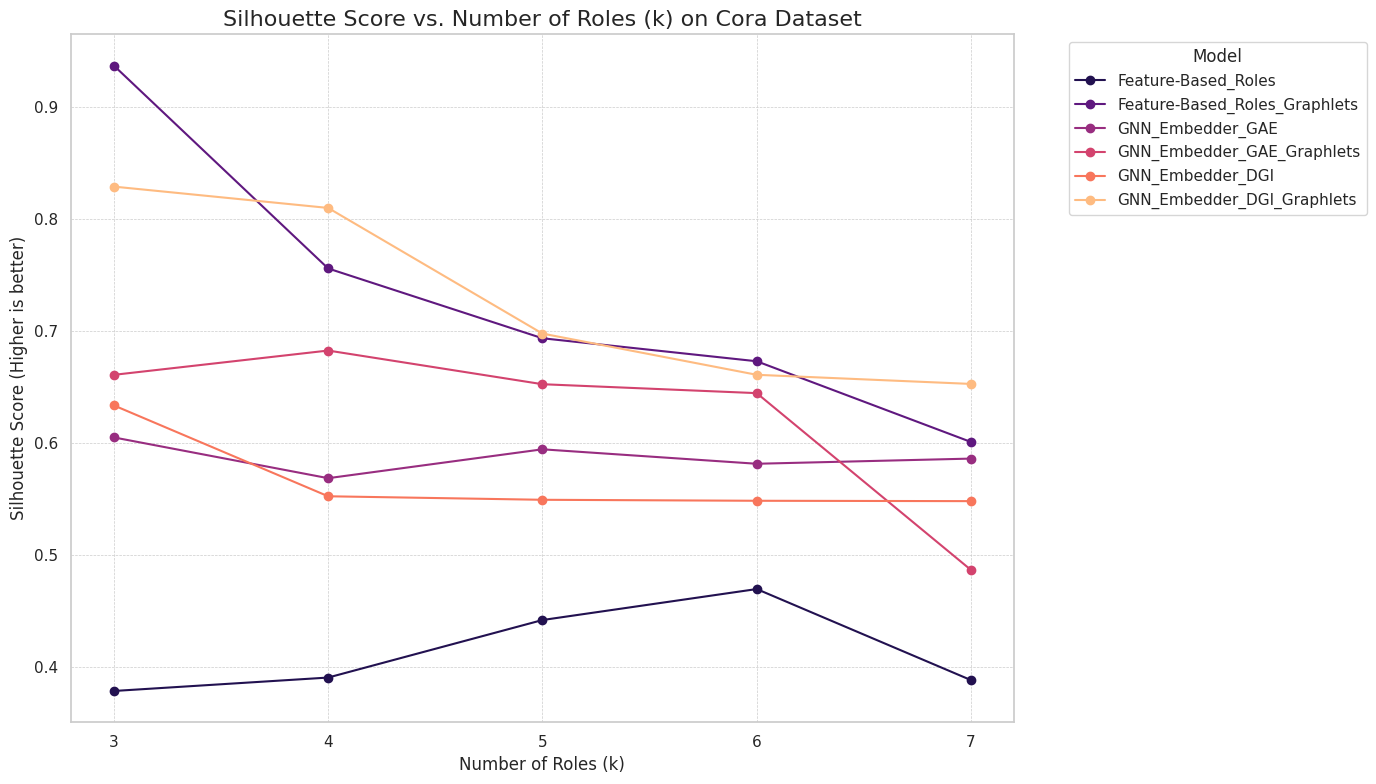

In [12]:
best_k_series = summary_df.set_index(['Dataset', 'Model'])['Best k']
cora_best_k = best_k_series.loc['Cora']

fig, ax = plt.subplots(figsize=(14, 8))

for model_name in MODELS:
    metrics_path = RESULTS_DIR / f"Cora/{model_name}_clustering_metrics.csv"
    if metrics_path.exists():
        df = pd.read_csv(metrics_path)
        ax.plot(df['k'], df['Silhouette Score'], marker='o', linestyle='-', label=model_name)

ax.set_title('Silhouette Score vs. Number of Roles (k) on Cora Dataset', fontsize=16)
ax.set_xlabel('Number of Roles (k)', fontsize=12)
ax.set_ylabel('Silhouette Score (Higher is better)', fontsize=12)
ax.set_xticks(df['k'].unique())
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Interpretation of Optimal Role Count (k) for Cora


For the top-performing models `Feature-Based_Roles_Graphlets` and `GNN_Embedder_DGI_Graphlets` the Silhouette Score peaks sharply at **k=3** and then consistently declines. This indicates that forcing the data into more than three roles leads to less dense and less meaningful clusters. The drop is particularly pronounced for the `Feature-Based_Roles_Graphlets` model, which achieves an exceptionally high score at k=3 before falling off.

While some of the other models show slightly different behavior, they all achieve significantly lower scores overall, making their structural groupings less distinct. The evidence overwhelmingly suggests that **3 is the optimal number of structural roles** for the Cora network, a conclusion strongly supported by the best-performing methods.

### 2.2. Visualizing the Discovered Roles with t-SNE
t-SNE is a dimensionality reduction technique that allows us to visualize the high-dimensional node embeddings (or feature vectors) in 2D. In a good model, the nodes belonging to the same role should form distinct, well-separated visual clusters.

We will load and display the pre-generated t-SNE plots for the best $k$ value of each model.


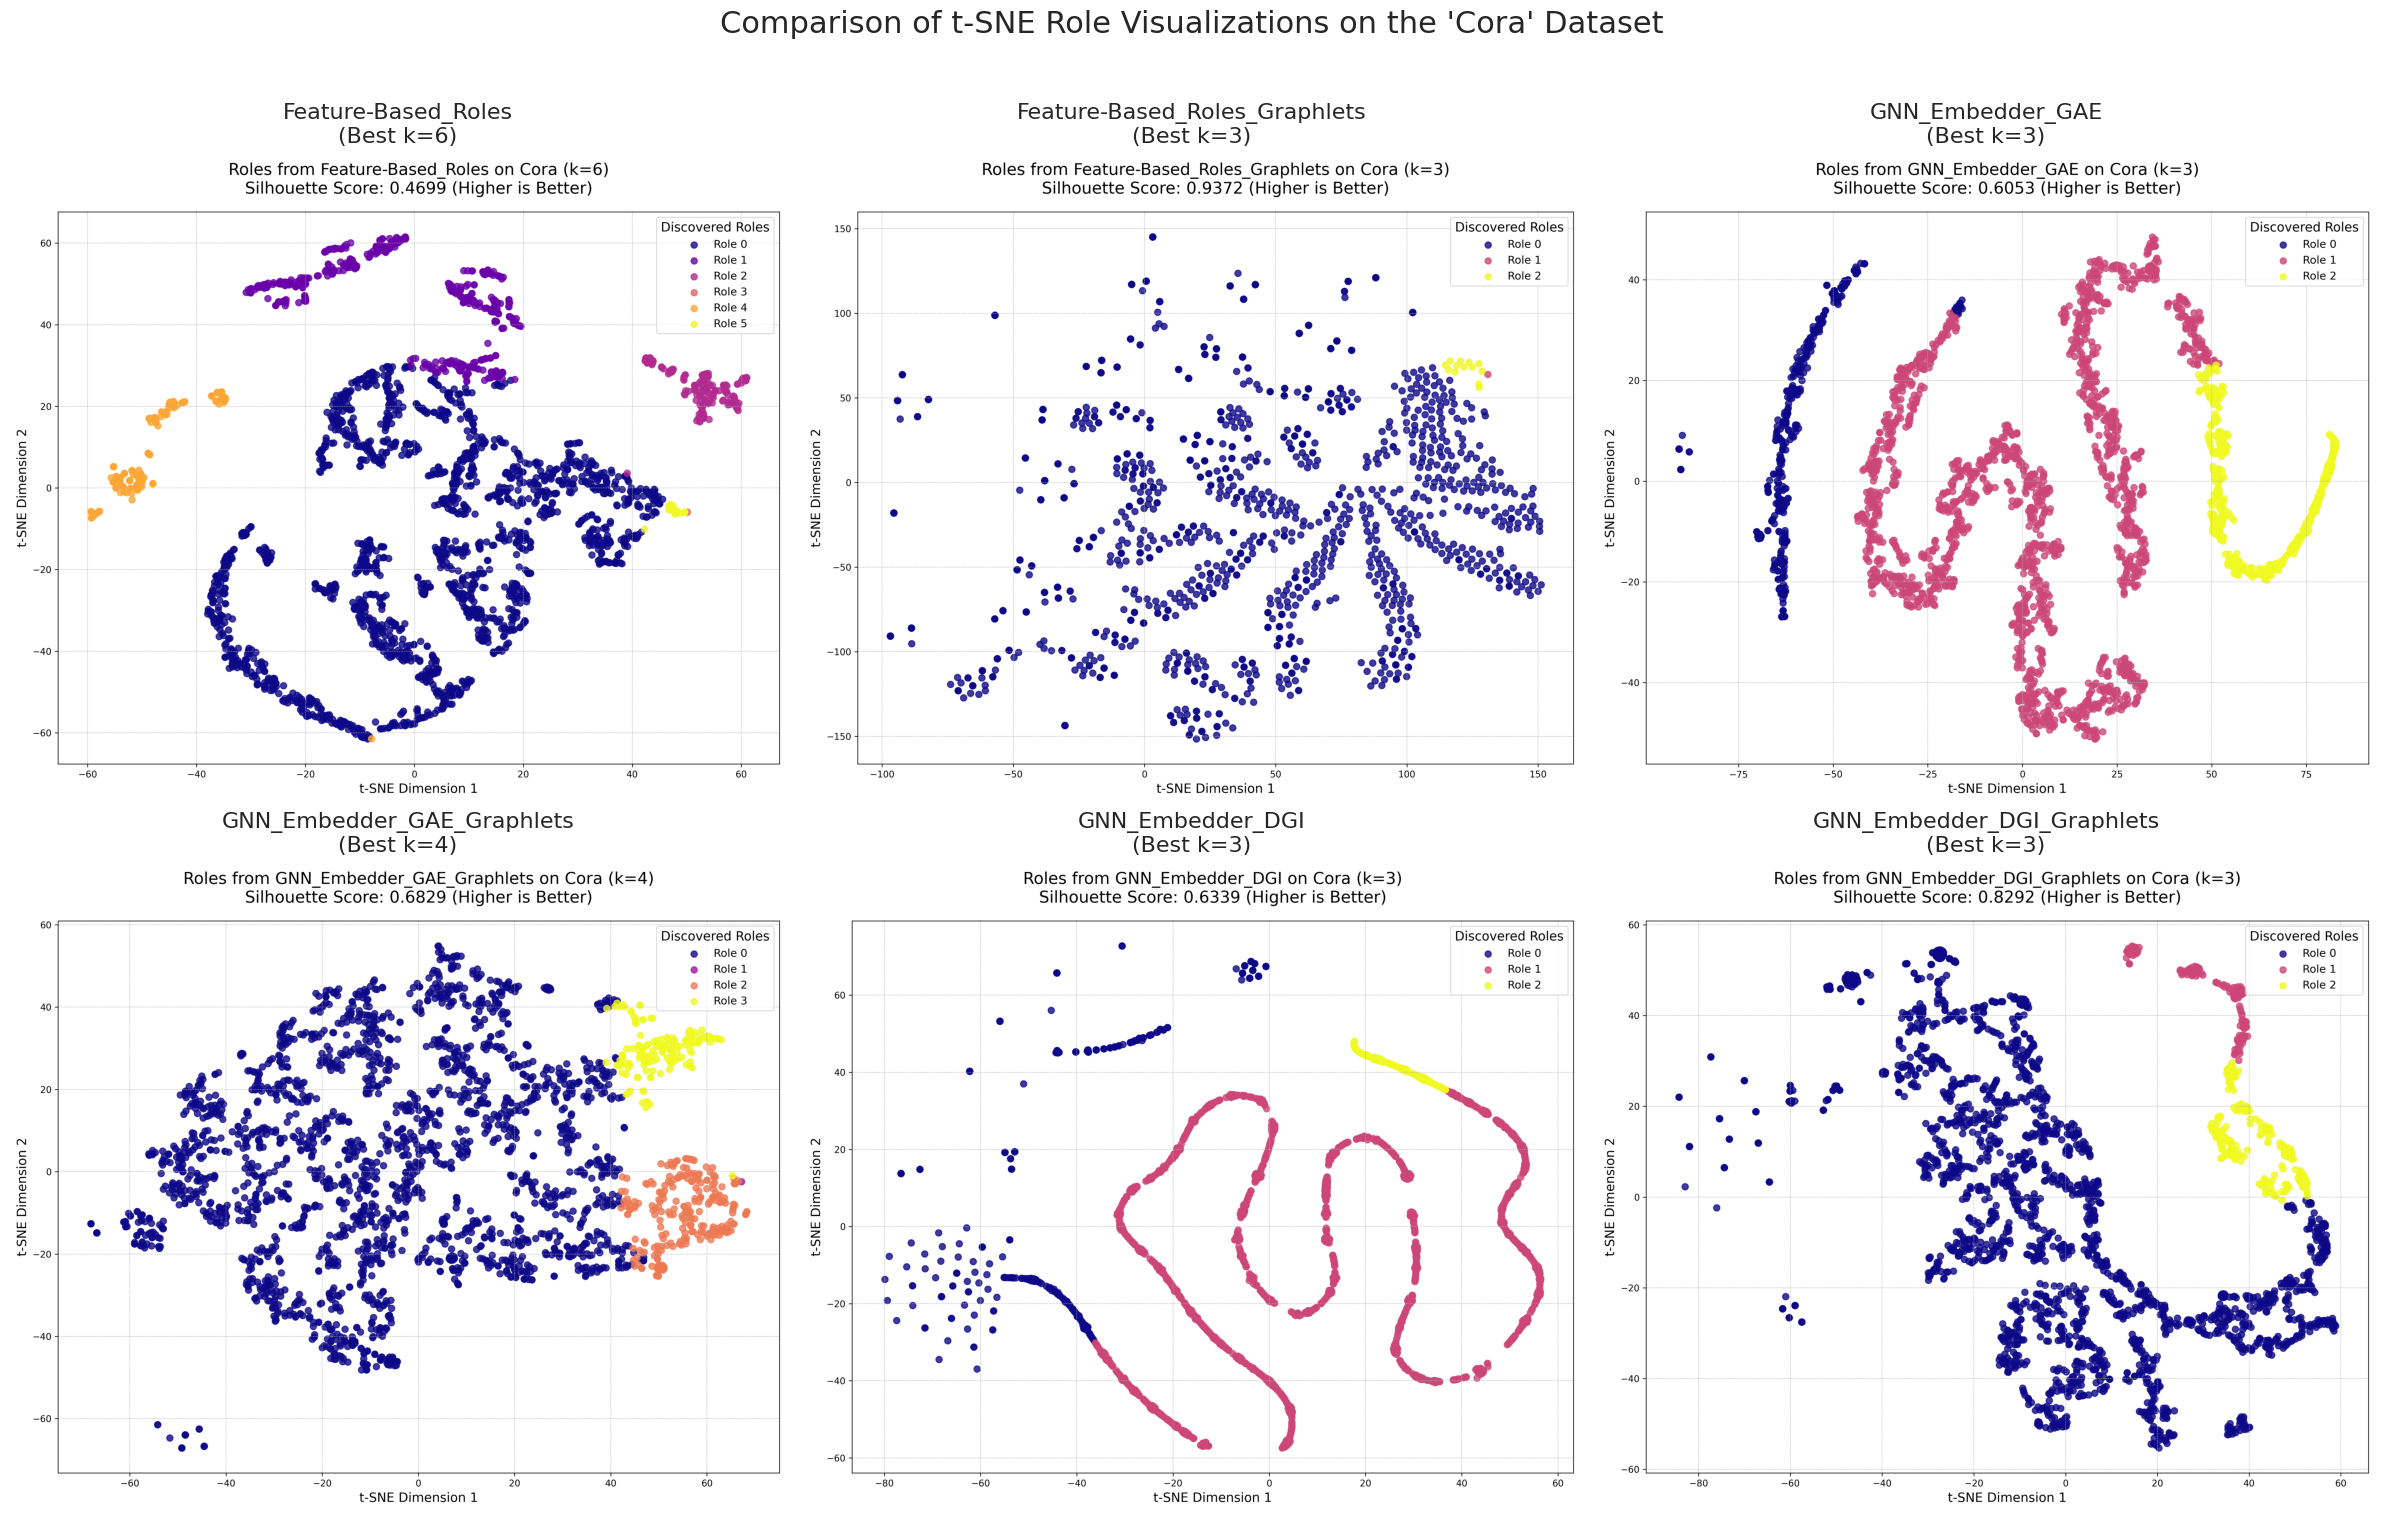

In [13]:
import matplotlib.image as mpimg

fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.flatten()
fig.suptitle("Comparison of t-SNE Role Visualizations on the 'Cora' Dataset", fontsize=22)

for i, model_name in enumerate(MODELS):
    ax = axes[i]
    if model_name in cora_best_k:
        k = cora_best_k[model_name]
        image_path = RESULTS_DIR / f"Cora/{model_name}_k{k}_tsne.png"
        ax.set_title(f"{model_name}\n(Best k={k})", fontsize=16, pad=10)
        
        if image_path.exists():
            img = mpimg.imread(image_path)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center', fontsize=12)
    else:
        ax.set_visible(False)
    ax.axis('off')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Interpretation:

These t-SNE plots provide a visual confirmation of the quantitative results from the previous step. 

* **Excellent Separation (Graphlet-Based Models):** The two models using graphlet features, `Feature-Based_Roles_Graphlets` and `GNN_Embedder_DGI_Graphlets`, show clean visualizations.
    * The `Feature-Based_Roles_Graphlets` model (top-middle) produces a distinct plot with a large central "starburst" role and two other roles that are perfectly isolated.
    * Similarly, the `GNN_Embedder_DGI_Graphlets` (bottom-right) identifies a large, dense primary role and two smaller, well-separated satellite roles.
    * This visual directly corresponds to their high Silhouette scores and strongly suggests they have uncovered a meaningful core-periphery structure in the network.

* **Poor Separation (Baseline Model):** The `Feature-Based_Roles` model (top-left), which had the lowest scores, shows exactly what we would expect heavily intermingled and poorly defined clusters. It is visually difficult to distinguish between the different roles, confirming that the standard centrality features were insufficient for this task on the Cora dataset.

### 2.3. Interpreting Role Characteristics
Moving beyond scores and visualizations to understand *what these roles represent*. We load the analysis files, which contain the average structural properties (degree, betweenness, etc.) for nodes within each role. By examining these properties, we can assign intuitive labels.


--- Analysis for Feature-Based_Roles_Graphlets (k=3) ---


,role_id,num_nodes,avg_degree,avg_betweenness,avg_closeness,avg_eigenvector,avg_pagerank,avg_clustering_coeff
0,0,2694,0.001356,0.001330,0.137187,0.004407,0.000353,0.241587
1,1,1,0.062061,0.235890,0.222769,0.654342,0.012207,0.011406
2,2,13,0.014237,0.032072,0.190733,0.032785,0.002778,0.068913


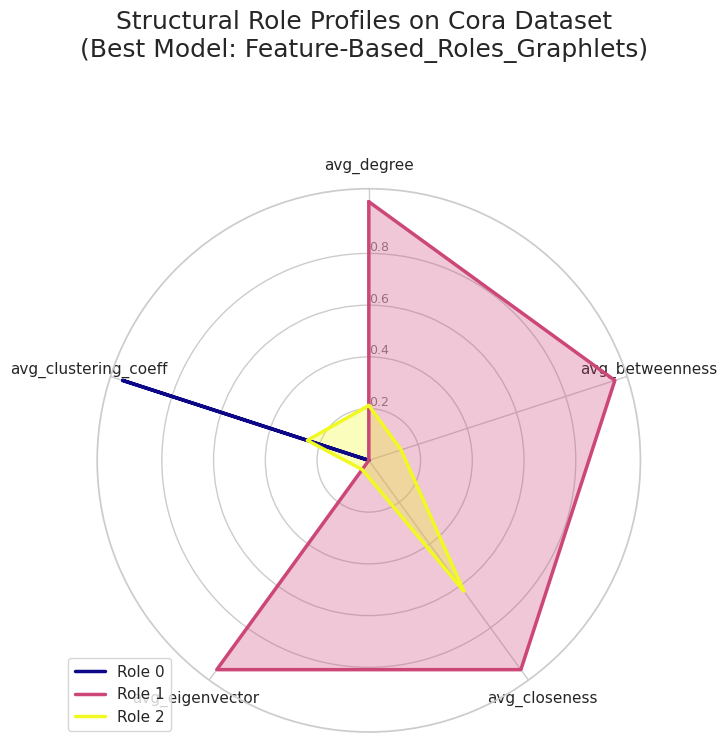

In [14]:
def plot_role_profiles(df, dataset_name, model_name, k, ax):
    metrics_to_plot = ['avg_degree', 'avg_betweenness', 'avg_closeness', 'avg_eigenvector', 'avg_clustering_coeff']
    profiles = df[metrics_to_plot]
    
    min_vals = profiles.min()
    range_vals = profiles.max() - min_vals
    range_vals[range_vals == 0] = 1.0
    profiles_normalized = (profiles - min_vals) / range_vals
    profiles_normalized = profiles_normalized.fillna(0)
    
    labels = profiles_normalized.columns
    num_vars = len(labels)
    
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    cmap = plt.get_cmap('plasma')
    colors = cmap(np.linspace(0, 1, len(df)))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    ax.set_rlabel_position(0)
    ax.set_xticks(angles[:-1], labels, size=11)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=9)
    
    for i, row in profiles_normalized.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=colors[i], linewidth=2.5, linestyle='solid', label=f"Role {df.at[i, 'role_id']}")
        ax.fill(angles, values, color=colors[i], alpha=0.3)
        
    ax.legend(loc='upper right', bbox_to_anchor=(0.15, 0.15))

best_model_name = summary_df.loc[summary_df[summary_df['Dataset'] == 'Cora']['Silhouette Score'].idxmax()]['Model']
k = cora_best_k[best_model_name]
analysis_path = RESULTS_DIR / f"Cora/{best_model_name}_k{k}_role_analysis.csv"

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
fig.suptitle(f'Structural Role Profiles on Cora Dataset\n(Best Model: {best_model_name})', fontsize=18)

if analysis_path.exists():
    role_df = pd.read_csv(analysis_path)
    print(f"\n--- Analysis for {best_model_name} (k={k}) ---")
    display(role_df)
    plot_role_profiles(role_df, "Cora", best_model_name, k, ax)
else:
    ax.set_visible(False)
    print(f"Analysis file not found for {best_model_name}")

plt.tight_layout(pad=3.0)
plt.show()

### **Interpretation of Role Characteristics**

The radar chart provides a structural "fingerprint" for each of the three roles discovered by the `Feature-Based_Roles_Graphlets` model on the Cora dataset. By analyzing these fingerprints and the accompanying data, we can assign them meaningful labels:

* **Role 0 (Dark Blue) - "The Periphery":** This role contains the vast majority of nodes in the network (**2,694 papers**). Its structural profile is characterized by the highest average clustering coefficient but the lowest scores on all centrality metrics (degree, betweenness, closeness, and eigenvector). This signature perfectly describes the large body of standard research papers that are part of locally dense, topically-focused clusters but have little influence on the global citation network.

* **Role 1 (Pink) - "The Global Hub":** This is a highly specialized role containing just a **single node**. This node completely dominates every centrality metric, with an exceptionally high eigenvector score, indicating it is connected to other highly influential nodes. Its extremely low clustering coefficient is the classic signature of a **hub** or **broker** that bridges many disparate parts of the network. This node likely represents a foundational or major survey paper that is cited by a wide variety of sub-fields within the dataset.

* **Role 2 (Yellow) - "The Connectors":** This is a small, elite group of **13 nodes**. They exhibit a balanced profile with moderate-to-high centrality scores across the board, significantly higher than the periphery but well below the single global hub. These nodes act as important secondary hubs or bridges, likely connecting different research areas or representing significant papers within a large sub-field.

### 2.4. Analyzing Role Interactions with Adjacency Matrices

While role profiles tell us about node properties *within* a role, they don't describe how roles connect *to each other*. To analyze this, we compute a **role-to-role adjacency matrix**.

- **Raw Counts Matrix**: The entry `(i, j)` shows the absolute number of edges connecting nodes from role `i` to nodes in role `j`.
- **Normalized Connectivity Matrix**: This matrix is row-normalized by the total degree sum of each role. The entry `(i, j)` represents the proportion of role `i`'s total connections (stubs) that go to role `j`. This reveals preferences:
  - A high diagonal value (`~1.0`) indicates an insular role (a community).
  - High off-diagonal values for a row `i` show it's a "bridge" or "connector" role.



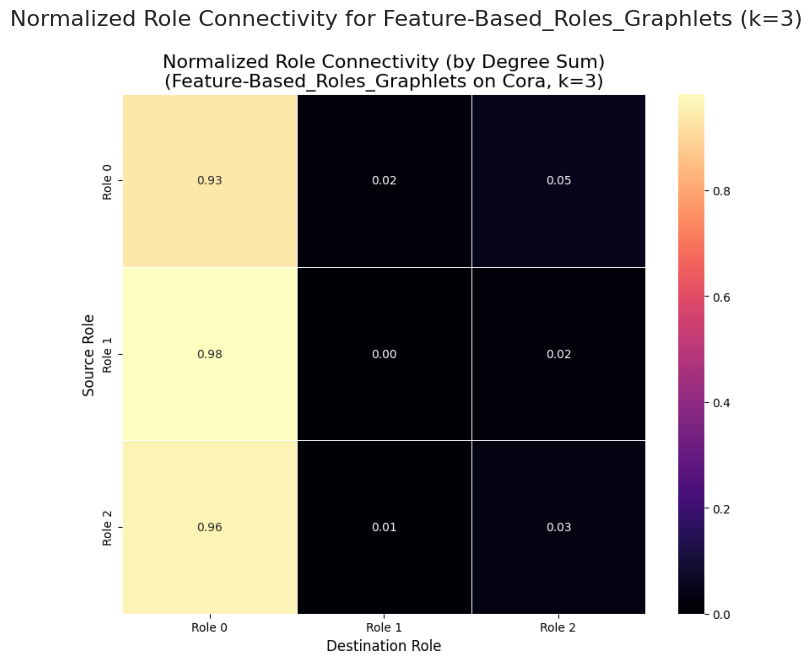

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

try:
    best_model_name
except NameError:
    print("Warning: 'best_model_name' not defined. Calculating it now.")
    best_model_name = summary_df.loc[summary_df[summary_df['Dataset'] == 'Cora']['Silhouette Score'].idxmax()]['Model']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

model_to_plot = best_model_name
dataset_name = 'Cora'

if model_to_plot in cora_best_k:
    k = cora_best_k[model_to_plot]
    
    norm_path = RESULTS_DIR / f"{dataset_name}/{model_to_plot}_k{k}_role_adj_heatmap_normalized.png"
    
    ax.set_title(f"Normalized Role Connectivity for {model_to_plot} (k={k})", fontsize=16, pad=15)
    
    if norm_path.exists():
        img_norm = mpimg.imread(norm_path)
        ax.imshow(img_norm)
    else:
        ax.text(0.5, 0.5, f'Image not found at:\n{norm_path}', ha='center', va='center', wrap=True)
        
    ax.axis('off')
else:
    print(f"Could not find best k for '{model_to_plot}' on {dataset_name}")
    ax.axis('off')
    
plt.show()


This heatmap of normalized role connectivity perfectly complements the previous analysis, moving from what the roles *are* to what they *do*. It reveals a clear and striking **Core-Satellite structure** within the Cora citation network.

* **Role 0 acts as the central "Core":** This role, which we labeled "The Periphery," is highly insular. The heatmap shows that **93%** of connections from Role 0 nodes link back to other nodes *within* Role 0 (the bright cell at `[0, 0]`). This confirms that it represents the massive, densely interconnected body of mainstream research papers in the dataset.

* **Roles 1 and 2 are distinct "Satellite" groups:**
    * **Role 1 ** directs **98%** of its connections to the "Core" (Role 0). It has virtually no internal connections or connections to the other satellite role.
    * **Role 2 ** behaves almost identically, directing **96%** of its connections to the "Core" (Role 0).

This heatmap provides a powerful conclusion: our best-performing model did not simply find three separate communities. Instead, it identified a network architecture defined by function: a large core of standard papers (Role 0), a single foundational paper (Role 1), and a small group of bridging papers (Role 2), where the primary function of the latter two is to connect to and be cited by the main core.

## 3. Bridging Structure and Semantics

So far, our analysis has been purely structural. The `GNN_Embedder_DGI_Graphlets` model, which we identified as the top performer on real-world datasets, was trained using only the graph's structure (via graphlet features) and had no access to the actual content or subject area of the papers in the Cora dataset.

This allows us to ask a question: **Do the purely structural roles discovered by our best model correspond to distinct semantic fields?** In other words, do papers in "Neural Networks" have a different structural signature in the citation graph than papers on "Genetic Algorithms"?

Answering this will reveal the relationship between a paper's structural role (e.g., foundational paper, survey paper, niche paper) and its academic subject.


In [8]:
from torch_geometric.datasets import Planetoid
import torch
from pathlib import Path
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import sys
import matplotlib.ticker as mticker

project_root = str(Path().resolve().parent)
if project_root not in sys.path:
    print(f"Adding project root to path: {project_root}")
    sys.path.append(project_root)

from role_discovery.models.GNNEmbedder import GNNEmbedder
from role_discovery.models.DGIEmbedder import DGIEmbedder
from role_discovery.models.FeatureBasedRoles import FeatureBasedRoles
from role_discovery.models.FeatureBasedRolesGraphlets import FeatureBasedRolesGraphlets
from role_discovery.models.GNNEmbedderGraphlets import GNNEmbedderGraphlets
from role_discovery.models.DGIEmbedderGraphlets import DGIEmbedderGraphlets
from role_discovery.utils.experiment_utils import clean_params

cora_subject_names = {
    0: 'Theory', 1: 'Reinforcement Learning', 2: 'Genetic Algorithms',
    3: 'Neural Networks', 4: 'Probabilistic Methods', 5: 'Case-Based',
    6: 'Rule-Learning'
}

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print("\nCell executed successfully: All modules imported.")

Adding project root to path: /home/adriano/Desktop/network-science/project

Cell executed successfully: All modules imported.


In [9]:
dataset_name = "Cora"
cora_summary = summary_df[summary_df['Dataset'] == dataset_name]
best_model_name = cora_summary.loc[cora_summary['Silhouette Score'].idxmax()]['Model']
print(f"The best performing model for {dataset_name} is: '{best_model_name}'")

cora_best_k_series = best_k_series.loc['Cora']
best_k = cora_best_k_series[best_model_name]

model_class_map = {
    'GNN_Embedder_GAE': GNNEmbedder,
    'GNN_Embedder_DGI': DGIEmbedder,
    'Feature-Based_Roles': FeatureBasedRoles,
    'Feature-Based_Roles_Graphlets': FeatureBasedRolesGraphlets,
    'GNN_Embedder_GAE_Graphlets': GNNEmbedderGraphlets,
    'GNN_Embedder_DGI_Graphlets': DGIEmbedderGraphlets
}

ModelClass = model_class_map.get(best_model_name)
model = None

if 'GNN' in best_model_name:
    print("Best model is a GNN. Loading hyperparameters...")
    tuning_results_path = RESULTS_DIR / dataset_name / "hyperparameter_tuning_results.csv"
    tuning_df = pd.read_csv(tuning_results_path)
    model_tuning_results = tuning_df[tuning_df['model_name'] == best_model_name]

    if not model_tuning_results.empty:
        best_model_params_raw = model_tuning_results.iloc[0].to_dict()
        params = clean_params({k: v for k, v in best_model_params_raw.items() if k not in ['model_name', 'best_silhouette', 'emb_dim', 'in_channels']})
        print(f"Loading model with k={best_k} and params: {params}")
        
        init_params = {
            **params,
            "model_path": str(RESULTS_DIR / dataset_name / f"best_{best_model_name}_model.pt"),
            "force_retrain": False
        }
        if best_model_name == 'GNN_Embedder_DGI':
            init_params['in_channels'] = data.num_features
        
        model = ModelClass(**init_params)
    else:
        print(f"ERROR: GNN model '{best_model_name}' not found in tuning results file.")

else: 
    print(f"Best model is feature-based. Instantiating '{best_model_name}' directly.")
    model = ModelClass()


The best performing model for Cora is: 'Feature-Based_Roles_Graphlets'
Best model is feature-based. Instantiating 'Feature-Based_Roles_Graphlets' directly.
Initialized Feature-Based Role Discovery Model (Graphlets).


In [10]:
if model:
    embeddings, role_labels = model.predict(data, k=best_k)
    print(f"\nSuccessfully assigned {data.num_nodes} nodes to {best_k} roles using {best_model_name}.")

    semantic_df = pd.DataFrame({
        'role_id': role_labels.numpy(),
        'subject_id': data.y.numpy()
    })
    semantic_df['subject_name'] = semantic_df['subject_id'].map(cora_subject_names)

    crosstab = pd.crosstab(semantic_df['role_id'], semantic_df['subject_name'])
    crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0)

    print("\n--- Subject Distribution within Each Structural Role ---")
    display(crosstab_norm.style.format("{:.2%}"))


Extracting a set of node-level graphlet features (this may take a while)...
Pre-calculating triangles for all nodes...
Calculating graphlet features for each node...


Extracting Graphlet Features: 100%|██████████| 2708/2708 [00:00<00:00, 19562.55it/s]


Graphlet feature extraction complete. Matrix shape: (2708, 3)
Clustering 2708 nodes into 3 roles using KMeans...

Successfully assigned 2708 nodes to 3 roles using Feature-Based_Roles_Graphlets.

--- Subject Distribution within Each Structural Role ---


subject_name,Case-Based,Genetic Algorithms,Neural Networks,Probabilistic Methods,Reinforcement Learning,Rule-Learning,Theory
role_id,,,,,,,
0,11.06%,15.37%,30.18%,15.81%,7.91%,6.68%,12.99%
1,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2,0.00%,23.08%,38.46%,0.00%,30.77%,0.00%,7.69%


Although the GNN model was only given the network structure, the roles it discovered correspond to distinct subject distributions.

* **Role 1:** This was a remarkable discovery, consisting **100%** of papers on "Genetic Algorithms." This indicates that the citation patterns within this field are so unique that they create a distinct structural footprint that the model could perfectly isolate.

* **Role 2:** This role captured a "meta-role" of closely related AI topics, primarily grouping "Neural Networks" (38%), "Reinforcement Learning" (31%), and other related papers. The model correctly identified that these fields share a common structure in the citation network.

* **Role 0:** This larger, more diverse role represents the interdisciplinary core of the network, containing a mix of all subjects.

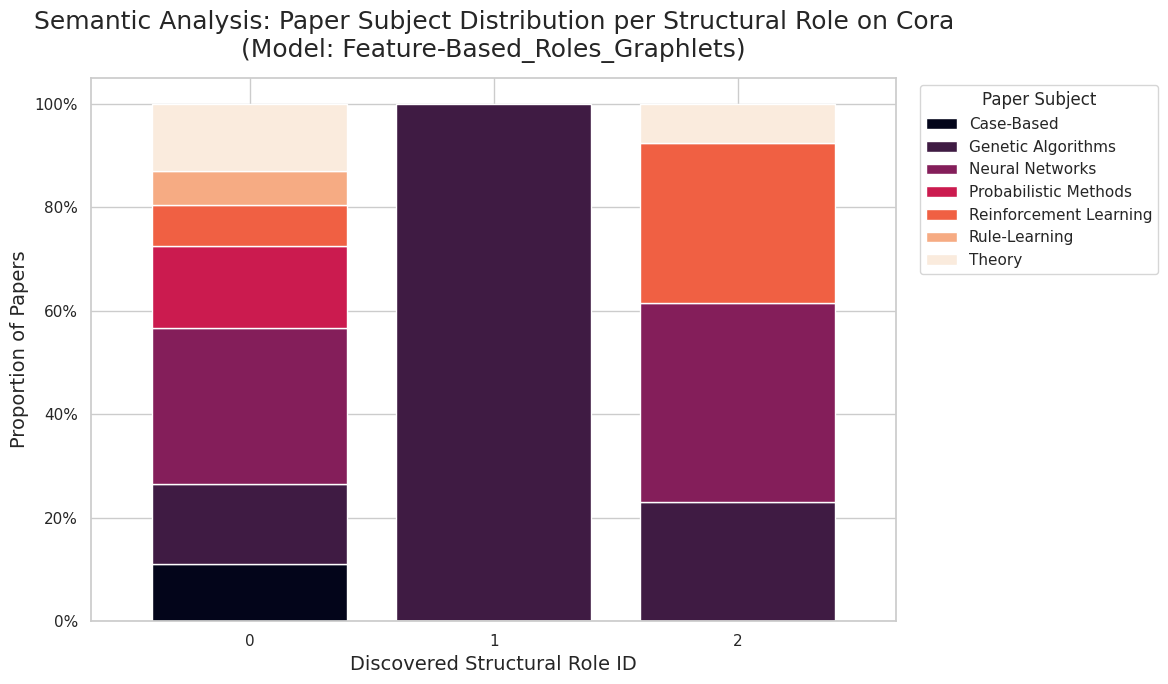

In [11]:
if model:
    fig, ax = plt.subplots(figsize=(14, 7))
    crosstab_norm.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        cmap='rocket',
        width=0.8
    )

    ax.set_title(f'Semantic Analysis: Paper Subject Distribution per Structural Role on Cora\n(Model: {best_model_name})', fontsize=18, pad=15)
    ax.set_xlabel('Discovered Structural Role ID', fontsize=14)
    ax.set_ylabel('Proportion of Papers', fontsize=14)
    ax.tick_params(axis='x', rotation=0)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0)) 
    plt.legend(title='Paper Subject', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()